In [ ]:
import sys
from pathlib import Path

project_root = str(Path.cwd().parents[3])
if project_root not in sys.path:
    sys.path.append(project_root)

In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networks import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import Adam
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCELoss
from tqdm import tqdm

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
questions = pd.read_pickle(os.path.join(Path.cwd().parent.parent.parent.parent,'data','stackexchange_reduced_tags_embeddings.pkl'))

In [3]:
count_cutoff = 5_000
tags_to_keep = questions['tags'].explode().value_counts()>count_cutoff
tags_to_keep = tags_to_keep[tags_to_keep].index.tolist()
tags_to_impute =questions['tags'].explode().value_counts()<=count_cutoff
tags_to_impute = tags_to_impute[tags_to_impute].index.tolist()
questions_filtered = questions.copy()

In [4]:
questions_filtered = questions.copy()
questions_filtered['tags'] = questions_filtered['tags'].apply(
    lambda tags: [tag for tag in tags if tag in tags_to_keep]
)
questions_filtered = questions_filtered[questions_filtered['tags'].apply(len) > 0]

In [5]:
len(tags_to_keep), questions_filtered.shape

(15, (76687, 3))

In [6]:
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(questions_filtered['tags'])

In [7]:
indices = questions_filtered.index.tolist()

In [8]:
X = np.vstack(questions_filtered['question_text_embedding'].values)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X, y_encoded, indices, test_size=0.15, random_state=42
)

In [9]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                            torch.tensor(y_val, dtype=torch.float32))

<Axes: xlabel='tags', ylabel='Count'>

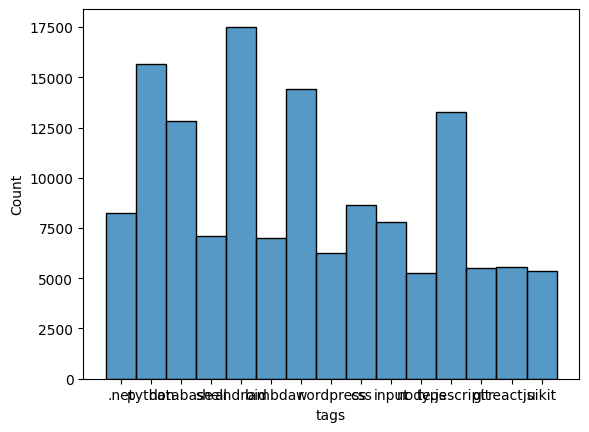

In [10]:
sns.histplot(questions_filtered['tags'].explode(), log_scale=True, bins=15)

Since question can have a very popular, and very rare tag, we can't just weigh all tags equally. Instead, we will penalize `BCEWithLogitsLoss` for missing a rare tag much more heavily than for missing a popular tag.

In [14]:
class_counts = y_train.sum(axis=0)
num_samples = len(y_train)
pos_weights = (num_samples - class_counts) / (class_counts + 1e-6)
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32)

In [18]:
model = BaselineNetwork(output_size=len(tags_to_keep))
model.to(device)

BaselineNetwork(
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=1024, out_features=15, bias=True)
)

In [19]:
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss(pos_weight=pos_weights_tensor.to(device))

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [22]:
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

Epoch [1/50], Loss: 0.41856223
Epoch [2/50], Loss: 0.34968230
Epoch [3/50], Loss: 0.31576762
Epoch [4/50], Loss: 0.38150287
Epoch [5/50], Loss: 0.42095160
Epoch [6/50], Loss: 0.31839573
Epoch [7/50], Loss: 0.27904466
Epoch [8/50], Loss: 0.30814394
Epoch [9/50], Loss: 0.33197120
Epoch [10/50], Loss: 0.26416507
Epoch [11/50], Loss: 0.26620573
Epoch [12/50], Loss: 0.25926235
Epoch [13/50], Loss: 0.18413648
Epoch [14/50], Loss: 0.26117775
Epoch [15/50], Loss: 0.16945013
Epoch [16/50], Loss: 0.17528260
Epoch [17/50], Loss: 0.19439574
Epoch [18/50], Loss: 0.16387413
Epoch [19/50], Loss: 0.14254440
Epoch [20/50], Loss: 0.12179038
Epoch [21/50], Loss: 0.11161200
Epoch [22/50], Loss: 0.11096162
Epoch [23/50], Loss: 0.08759756
Epoch [24/50], Loss: 0.11643307
Epoch [25/50], Loss: 0.11425650
Epoch [26/50], Loss: 0.10584780
Epoch [27/50], Loss: 0.07687488
Epoch [28/50], Loss: 0.06536148
Epoch [29/50], Loss: 0.08052932
Epoch [30/50], Loss: 0.05358307
Epoch [31/50], Loss: 0.06304262
Epoch [32/50], Lo

In [23]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
model.eval()
all_preds = {}
threshold = 0.5
all_predictions = []
with torch.no_grad():
    for batch_X, batch_y in tqdm(val_loader):
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        probs = torch.sigmoid(logits)
        predictions = (probs > threshold).int().cpu().numpy()
        all_predictions.append(predictions)
all_predictions = np.vstack(all_predictions)

for idx, pred in zip(idx_val, all_predictions):
    all_preds[idx] = pred

100%|██████████| 360/360 [00:00<00:00, 1576.78it/s]


In [24]:
from sklearn.metrics import f1_score
f1_score(y_val, all_predictions, average='weighted')

0.7577447899998021

In [25]:
def plot_classification_report(y_true, y_pred, mlb):
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=mlb.classes_, 
        output_dict=True
    )
    
    df_report = pd.DataFrame(report).transpose()
    
    df_classes = df_report.iloc[:-4]  
    
    plt.figure(figsize=(10, len(mlb.classes_) * 0.3))
    sns.heatmap(df_classes[['precision', 'recall', 'f1-score']], 
                annot=True, 
                cmap='viridis', 
                fmt='.2f')
    plt.title("Per-Tag Performance")
    plt.show()

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


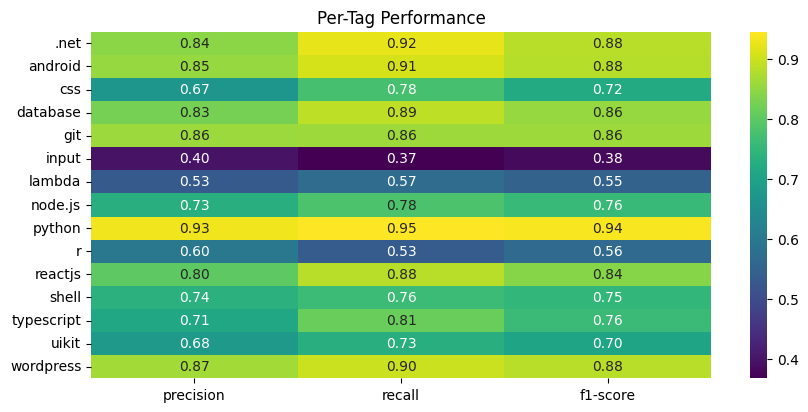

In [26]:
plot_classification_report(y_val, all_predictions, mlb)

In [27]:
from sklearn.metrics import multilabel_confusion_matrix
def plot_specific_tag_cm(y_true, y_pred, mlb, tag_name):
    try:
        tag_idx = list(mlb.classes_).index(tag_name)
    except ValueError:
        print(f"Tag '{tag_name}' not found.")
        return

    mcm = multilabel_confusion_matrix(y_true, y_pred)
    cm = mcm[tag_idx]
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Predicted', 'Predicted'],
                yticklabels=['Actual Not', 'Actual Yes'])
    plt.title(f"Confusion Matrix for: {tag_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

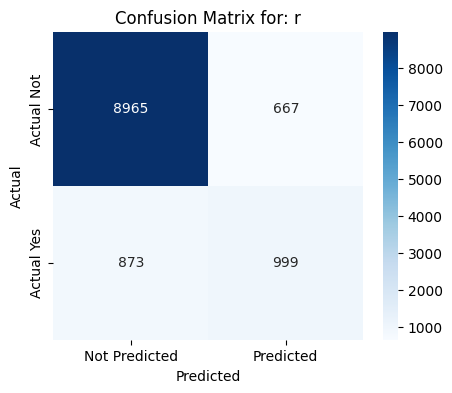

In [29]:
plot_specific_tag_cm(y_val, all_predictions, mlb, 'r')